# Target-embedded autoencoders

In [1]:
import typing
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
from torch import nn, optim, tensor, FloatTensor
from torch.utils.data import Dataset, TensorDataset, DataLoader, random_split
import torch.nn.functional as F

from fastai.basics import *

from tea_models import LinearMLP

import matplotlib.pyplot as plt

In [2]:
synthetic_expression_data = pd.read_csv("data/net1_expression_data.tsv", sep='\t')
chip_features = pd.read_csv("data/net1_chip_features.tsv", sep='\t')
gene_ids = pd.read_csv("data/net1_gene_ids.tsv", sep='\t')
tfs = pd.read_csv("data/net1_transcription_factors.tsv", sep='\t')

In [3]:
X_idx = [g in tfs.iloc[:,0].tolist() for g in synthetic_expression_data.columns]

In [4]:
synthetic_expression_data.values.shape

(805, 1643)

In [5]:
train, valid, test = map(torch.FloatTensor, (
    synthetic_expression_data.values[:500, :], 
    synthetic_expression_data.values[500:700, :],
    synthetic_expression_data.values[700:, :]))

In [6]:
batch_size = 128
train_ds = TensorDataset(train[:, X_idx], train)
valid_ds = TensorDataset(valid[:, X_idx], valid)
test_ds = TensorDataset(test[:, X_idx], test)
data = DataBunch.create(train_ds, valid_ds, bs = batch_size)

In [7]:
X, Y = next(iter(data.train_dl))
X.shape, Y.shape

(torch.Size([128, 194]), torch.Size([128, 1643]))

In [8]:
# class LFEA(nn.Module):
#     """A pytorch module to build a linear forward-embedding autoencoder"""

#     def __init__(self, input_dim = 194, hidden_dim = 256, output_dim = 1643):
#         """
#         Parameters
#         ----------
#         input_dim : int
#             The number of input features
#         hidden_dim : int
#             The number of features in the hidden layer
#         output_dim : int
#             The number of output features
#         """
#         super().__init__()
#         self.fc1 = nn.Linear(input_dim, hidden_dim)
#         self.fc2 = nn.Linear(hidden_dim, output_dim)
  
#     def forward(self, X):
#         X = self.fc1(X)
#         X = self.fc2(X)
#         return X

In [9]:
loss_func = nn.MSELoss()
input_dim = sum(X_idx)
hidden_dim = 256
output_dim = synthetic_expression_data.shape[1]

In [10]:
lmlp_model = LinearMLP(input_dim, hidden_dim, output_dim)

In [11]:
def update_batch(model, X, Y, lr, train = True):
    """update_batch takes a model, data, a learning rate and a boolean indicating whether this update 
    should be treated as a training run (i.e. the model's weights should be updated) 
    or not. This function is not for production use, as it has a number of hidden parameters (e.g. optimizer).  
    
    Parameters
    ----------
    model : torch.nn.mnodule
        The model to be updated
    X : torch.FloatTensor
        The input data (i.e feature matrix)
    Y : torch.FloatTensor
        The target matrix)
    lr : float
        The learning rate to be passed to the optimizer
    train : bool
        Should the weights be updated (default = True)
    """
    Y_hat = model(X)
    loss = loss_func(Y_hat, Y)
    if train:
        opt = optim.Adam(model.parameters(), lr)
        loss.backward()
        opt.step()
        opt.zero_grad()
    return loss.item()

In [12]:
epochs = 8
lr = 5e-4
train_loss, valid_loss = [], []
for e in tqdm(range(epochs)):
    this_train_loss = np.mean([update_batch(lmlp_model, X, Y, lr) for X, Y in data.train_dl])
    this_valid_loss = np.mean([update_batch(lmlp_model, X, Y, lr, train=False) for X, Y in data.valid_dl])
    train_loss.append(this_train_loss)
    valid_loss.append(this_valid_loss)

100%|██████████| 8/8 [00:01<00:00,  6.04it/s]


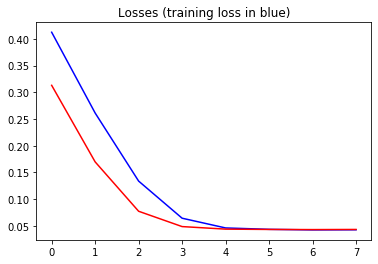

In [13]:
# plot losses
plt.plot([e for e in range(epochs)], train_loss, 'b')
plt.plot([e for e in range(epochs)], valid_loss, 'r')
plt.title("Losses (training loss in blue)")
plt.show()

In [14]:
test_loss = np.mean([update_batch(lmlp_model, X, Y, lr, train=False) for X, Y in data.valid_dl])
print("Final test MSE loss: {}".format(test_loss))

Final test MSE loss: 0.043191755190491676


### Visualise predicted vs. actual

In [17]:
X, Y = next(iter(data.valid_dl))
X.shape, Y.shape

(torch.Size([128, 194]), torch.Size([128, 1643]))

In [18]:
Y_hat = lmlp_model(X[5]).detach().numpy()
Y_obs = Y[5].detach().numpy()

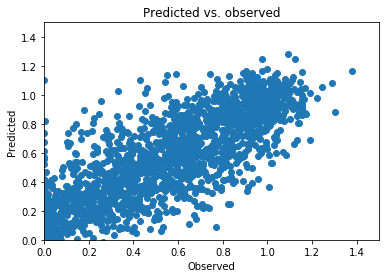

In [19]:
plt.scatter(Y_obs, Y_hat)
plt.title("Predicted vs. observed");
plt.xlim(0, 1.5)
plt.ylim(0, 1.5)
plt.xlabel("Observed");
plt.ylabel("Predicted");